# EfficientNet-B0

# 데이터 로드

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

## 전체 데이터 로드 (val/test)

In [2]:
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing

import gdown, os, zipfile

file_id = '1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)


# 전체 데이터 로드
def load_data(base_dir = 'hair-loss/Training'):
    images = []
    labels = []
    class_names = []

    for class_name in os.listdir(base_dir):
        class_name_path = os.path.join(base_dir, class_name)

        # 디렉토리인 경우만
        if os.path.isdir(class_name_path):
            for image_name in os.listdir(class_name_path):
                image_path = os.path.join(class_name_path, image_name)
                images.append(image_path)
                labels.append(int(class_name))

    return images, np.array(labels)

images, labels = load_data()

print(labels.shape)

Downloading...
From (original): http://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F
From (redirected): https://drive.google.com/uc?id=1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F&confirm=t&uuid=05461828-ef6f-49c8-bfdc-568512fb6767
To: /content/file.zip
100%|██████████| 1.25G/1.25G [00:19<00:00, 65.2MB/s]


(5402,)


## 데이터 resize

In [3]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5402, 224, 224, 3)
(5402,)


## 데이터 분할 -> test/val 만 사용

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
# train : val : test = 70 : 15 : 15
# 1. train : test + val = 60:40
train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42, stratify=labels
)

# 2. test : val = 50 : 50
test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels
)


train_images, test_images, val_images = np.array(train_images), np.array(test_images), np.array(val_images)
train_labels, test_labels, val_labels = np.array(train_labels), np.array(test_labels), np.array(val_labels)

# 결과 확인
print(f'Train data: {train_images.shape}, {train_labels.shape}')
print(f'Validation data: {val_images.shape}, {val_labels.shape}')
print(f'Test data: {test_images.shape}, {test_labels.shape}')

Train data: (3781, 224, 224, 3), (3781,)
Validation data: (811, 224, 224, 3), (811,)
Test data: (810, 224, 224, 3), (810,)


## Sequence Subclass 작성
- batch 크기 별로 이미지를 로드해서 -> 모델 학습에 제공하는 class
- 리사이즈/이미지 증강/스케일링 등의 작업이 필요하다면, `__getitem()__` 안에 작성할 수 있다.
---
순서 요약
1. 리사이즈: 모델 입력 크기에 맞게 조정.
2. 증강: 회전, 잘라내기, 밝기 조정 등 데이터 변형.
3. 스케일링: 데이터를 [0, 1] 또는 [-1, 1]로 정규화.

In [5]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2



class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], 224, 224, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 스케일링
      if self.preprocess_function is not None:
        imag = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


## 학습 / 검증/ 평가 데이터셋 별 Sequence 객체 생성

In [6]:
# 이미지증강/shuffle 적용
import albumentations as A

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)
])

tr_seq = HairLossSequence(train_images, train_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE, augmentor=augmentor, shuffle=True) # 증강은 훈련셋만
val_seq = HairLossSequence(val_images, val_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)
test_seq = HairLossSequence(test_images, test_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)

len(tr_seq), len(val_seq), len(test_seq)

# print(type(tr_seq[0]))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(119, 26, 26)

# Efficient Net B0 전이학습

- EfficientNet B0 로드: include_top=False로 설정하여 Fully Connected Layer(FC layer)를 제외하고 특성 추출에만 사용합니다.
- Custom Head 추가: 탈모 진단을 위한 맞춤 분류 레이어를 추가합니다.
- 모델 컴파일: 손실 함수, 옵티마이저 등을 설정합니다.

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers

def create_pretrained_efficientnet():
    # Bottom (특성 추출층)
    base_model = tf.keras.applications.EfficientNetB0(
        input_shape=(224,224,3),
        include_top = False,
        weights = 'imagenet', # 학습된 가중치
    )

    # 모든 레이어를 동결하여 학습되지 않도록 설정
    base_model.trainable = False

    # base model의 아웃풋 가져오기
    x = base_model.output

    # Top(전이층) 직접 만들기
    x = layers.GlobalAveragePooling2D()(x)  # GAP 레이어로 특성 맵을 1D로 축소
    x = layers.Dropout(0.5)(x)  # 과적합 방지
    x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(x)  # Dense Layer
    x = layers.Dropout(0.5)(x)  # 과적합 방지
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)  # Dense Layer
    x = layers.Dropout(0.5)(x)  # 과적합 방지
    x = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(x)  # Dense Layer
    x = layers.Dropout(0.3)(x)  # 과적합 방지
    x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(x)  # Dense Layer
    output = layers.Dense(4, activation='softmax')(x)  # 최종 출력층 (4 클래스 분류)

    # 최종 모델 구성
    model = Model(inputs=base_model.input, outputs=output)

    # Fine-Tuning 설정 - EfficientNet의 모든 층을 학습하지 않도록
    base_model.trainable = False

    # Fine_Tuning을 위해 일부 층 학습 가능하도록 (마지막 10개 층)
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    # 초기 컴파일 (Feature Extractor로서만 사용)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 모델 생성
model = create_pretrained_efficientnet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,878,183 (18.61 MB)

 Trainable params: 2,324,772 (8.87 MB)

 Non-trainable params: 2,553,411 (9.74 MB)

In [8]:
# @title Class weights 적용

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 클래스 라벨과 샘플 수를 기반으로 가중치 계산
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# 딕셔너리 형태로 변환
class_weight_dict = dict(enumerate(class_weights))

print(class_weight_dict)

{0: 2.5274064171122994, 1: 5.763719512195122, 2: 0.3556245297215952, 3: 1.6158119658119658}


## 모델 컴파일

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 88s 378ms/step - accuracy: 0.3133 - loss: 1.4369 - val_accuracy: 0.4797 - val_loss: 0.9677 - learning_rate: 0.0010
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.3987 - loss: 1.0296 - val_accuracy: 0.3909 - val_loss: 1.0777 - learning_rate: 0.0010
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.4311 - loss: 0.8131 - val_accuracy: 0.4340 - val_loss: 1.0419 - learning_rate: 0.0010
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.4340 - loss: 0.8033 - val_accuracy: 0.6449 - val_loss: 0.8437 - learning_rate: 0.0010
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5229 - loss: 0.6663 - val_accuracy: 0.5203 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.5468 - loss: 0.6408 - val_accuracy: 0.5845 - val_loss: 0.8902 - learning_rate: 0.0010
Epoch 7/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - accuracy: 0.5842 - loss: 0.5580 - 

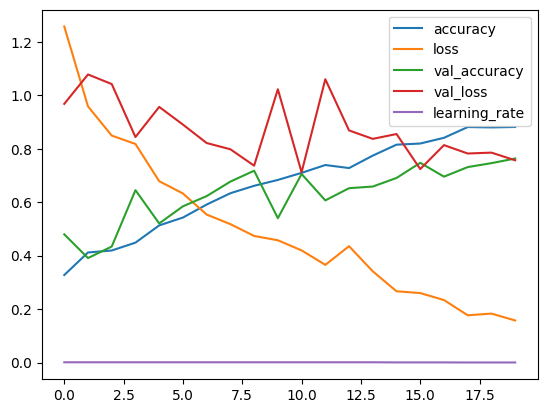

 3/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6927 - loss: 0.6945

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 321ms/step - accuracy: 0.6824 - loss: 0.7788


Test - loss: 0.8034, accuracy: 0.6852


In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=Adam(learning_rate=0.001),
#     metrics=['accuracy']
# )

# 콜백 정의
early_stop = EarlyStopping(monitor='val_loss', patience=9, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001, verbose=1)


# 학습
history = model.fit(
    tr_seq,
    epochs=30,
    batch_size = 32,
    validation_data=val_seq,
    class_weight=class_weight_dict,
    callbacks=[early_stop, checkpoint, reduce_lr])


# 학습결과 시각화
pd.DataFrame(history.history).plot()
plt.show()

# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'Test - loss: {loss:.4f}, accuracy: {accuracy:.4f}')

# 모델 저장
model.save(f'EfficientnetB0.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')  # .h5 확장자 파일로 저장

In [10]:
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.327427,1.257258,0.479655,0.967697,0.001
1,0.411796,0.958236,0.390875,1.077711,0.001
2,0.419201,0.848992,0.434032,1.041850,0.001
3,0.448559,0.817691,0.644883,0.843691,0.001
4,0.513092,0.678386,0.520345,0.956357,0.001


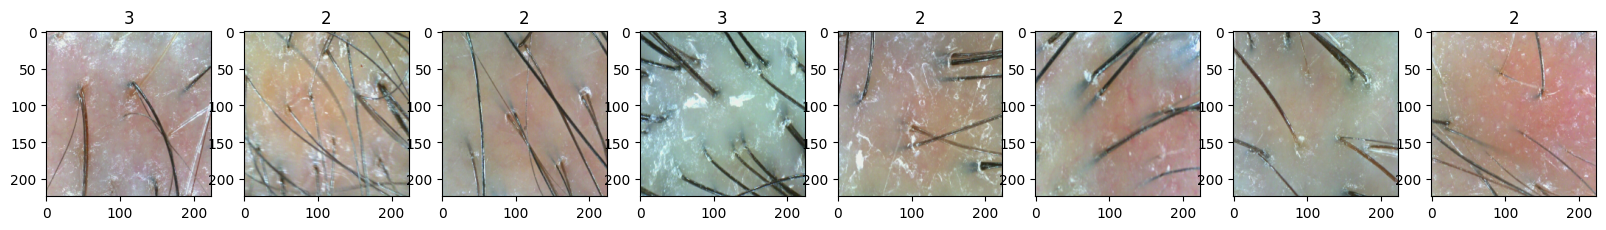

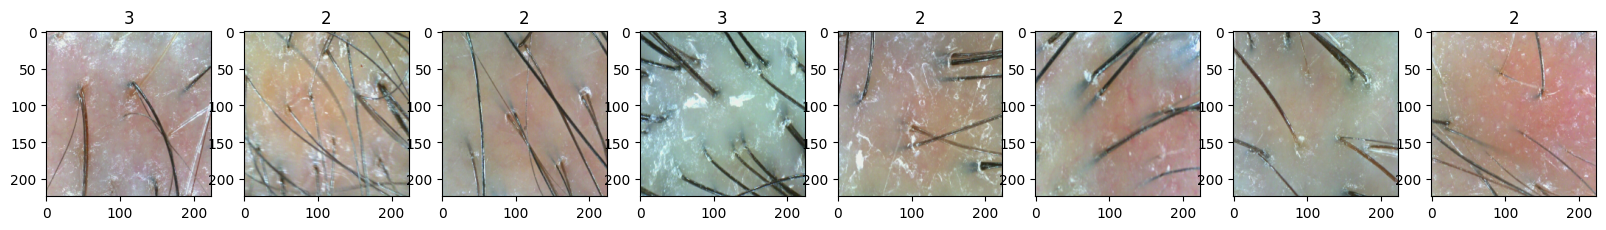

In [11]:
def show_images(images, labels, ncols=8):
    fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(20, 6))
    for i in range(ncols):
        ax[i].imshow(images[i])
        ax[i].set_title(labels[i])
    plt.show()


show_images(test_images[:8], test_labels[:8]) # 실제
show_images(test_images[:8], test_labels[:8]) #예측